# C25 vs. SP500

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import numpy as np
from sklearn.ensemble import RandomForestClassifier


## Collecting and cleaning

In [433]:
df_sp500 = pd.read_csv('/Users/lassekh/Downloads/HistoricalData_1728553884551.csv')
df_c25 = pd.read_excel('/Users/lassekh/Downloads/EODHist_20101220-20241010_OMXC25.xlsx')

In [369]:
df_sp500

,Date,Close/Last,Open,High,Low
0,10/09/2024,5792.04,5751.80,5796.80,5745.02
1,10/08/2024,5751.13,5719.14,5757.60,5714.56
2,10/07/2024,5695.94,5737.80,5739.34,5686.85
3,10/04/2024,5751.07,5737.48,5753.21,5702.83
4,10/03/2024,5699.94,5698.19,5718.78,5677.37
...,...,...,...,...,...
2522,10/16/2014,1862.76,1855.95,1876.01,1835.02
2523,10/15/2014,1862.49,1874.18,1874.18,1820.66
2524,10/14/2014,1877.70,1877.11,1898.71,1871.79
2525,10/13/2014,1874.74,1905.65,1912.09,1874.14


In [370]:
df_c25

,Trade Date,Index Value,Net Change,High,Low
0,2024-10-10,0.000000,0.000000,0.000000,0.000000
1,2024-10-09,1947.533006,5.520383,1948.161477,1931.457999
2,2024-10-08,1942.012623,4.257684,1948.941892,1924.925075
3,2024-10-07,1937.754940,21.572329,1938.147366,1910.903601
4,2024-10-04,1916.182611,5.042233,1932.215445,1909.173594
...,...,...,...,...,...
3451,2010-12-27,544.353310,0.000000,0.000000,0.000000
3452,2010-12-23,546.605932,0.000000,0.000000,0.000000
3453,2010-12-22,542.778001,0.000000,0.000000,0.000000
3454,2010-12-21,544.980134,0.000000,0.000000,0.000000


Dropping the first row of the df_c25 because it only contains 0.000 values.

In [434]:
df = df_c25.drop(index=0).reset_index(drop=True)
df

,Trade Date,Index Value,Net Change,High,Low
0,2024-10-09,1947.533006,5.520383,1948.161477,1931.457999
1,2024-10-08,1942.012623,4.257684,1948.941892,1924.925075
2,2024-10-07,1937.754940,21.572329,1938.147366,1910.903601
3,2024-10-04,1916.182611,5.042233,1932.215445,1909.173594
4,2024-10-03,1911.140378,-14.232112,1923.973828,1908.612972
...,...,...,...,...,...
3450,2010-12-27,544.353310,0.000000,0.000000,0.000000
3451,2010-12-23,546.605932,0.000000,0.000000,0.000000
3452,2010-12-22,542.778001,0.000000,0.000000,0.000000
3453,2010-12-21,544.980134,0.000000,0.000000,0.000000


In [435]:
df_c25['Date'] = pd.to_datetime(df_c25['Trade Date'])
df_c25 = df_c25.drop(columns='Trade Date')
df_c25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3456 entries, 0 to 3455
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Index Value  3456 non-null   float64       
 1   Net Change   3456 non-null   float64       
 2   High         3456 non-null   float64       
 3   Low          3456 non-null   float64       
 4   Date         3456 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 135.1 KB


In [436]:
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2527 non-null   datetime64[ns]
 1   Close/Last  2527 non-null   float64       
 2   Open        2527 non-null   float64       
 3   High        2527 non-null   float64       
 4   Low         2527 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 98.8 KB


In [437]:
df = pd.merge(df_sp500, df_c25, how='outer', on='Date', suffixes=('_sp500', '_c25'))
df = df.sort_values(by='Date').reset_index(drop=True)
df

,Date,Close/Last,Open,High_sp500,Low_sp500,Index Value,Net Change,High_c25,Low_c25
0,2010-12-20,NaN,NaN,NaN,NaN,542.094259,0.000000,0.000000,0.000000
1,2010-12-21,NaN,NaN,NaN,NaN,544.980134,0.000000,0.000000,0.000000
2,2010-12-22,NaN,NaN,NaN,NaN,542.778001,0.000000,0.000000,0.000000
3,2010-12-23,NaN,NaN,NaN,NaN,546.605932,0.000000,0.000000,0.000000
4,2010-12-27,NaN,NaN,NaN,NaN,544.353310,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
3533,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594
3534,2024-10-07,5695.94,5737.80,5739.34,5686.85,1937.754940,21.572329,1938.147366,1910.903601
3535,2024-10-08,5751.13,5719.14,5757.60,5714.56,1942.012623,4.257684,1948.941892,1924.925075
3536,2024-10-09,5792.04,5751.80,5796.80,5745.02,1947.533006,5.520383,1948.161477,1931.457999


Drop NaN values, because i need data from both data sets to be useful.

In [438]:
df = df.dropna().reset_index(drop=True)
df

,Date,Close/Last,Open,High_sp500,Low_sp500,Index Value,Net Change,High_c25,Low_c25
0,2014-10-10,1906.13,1925.63,1936.98,1906.05,750.032813,0.000000,0.000000,0.000000
1,2014-10-13,1874.74,1905.65,1912.09,1874.14,746.560781,0.000000,0.000000,0.000000
2,2014-10-14,1877.70,1877.11,1898.71,1871.79,749.100715,0.000000,0.000000,0.000000
3,2014-10-15,1862.49,1874.18,1874.18,1820.66,732.529282,0.000000,0.000000,0.000000
4,2014-10-16,1862.76,1855.95,1876.01,1835.02,719.147913,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2440,2024-10-03,5699.94,5698.19,5718.78,5677.37,1911.140378,-14.232112,1923.973828,1908.612972
2441,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594
2442,2024-10-07,5695.94,5737.80,5739.34,5686.85,1937.754940,21.572329,1938.147366,1910.903601
2443,2024-10-08,5751.13,5719.14,5757.60,5714.56,1942.012623,4.257684,1948.941892,1924.925075


df['Net Change'] contains a lot of 0.0000 values, and they can be calculated. So i will do that.

In [439]:
df.loc[df['Net Change'] == 0, 'Net Change'] = df['Index Value'] - df['Index Value'].shift(1)
df

,Date,Close/Last,Open,High_sp500,Low_sp500,Index Value,Net Change,High_c25,Low_c25
0,2014-10-10,1906.13,1925.63,1936.98,1906.05,750.032813,NaN,0.000000,0.000000
1,2014-10-13,1874.74,1905.65,1912.09,1874.14,746.560781,-3.472032,0.000000,0.000000
2,2014-10-14,1877.70,1877.11,1898.71,1871.79,749.100715,2.539934,0.000000,0.000000
3,2014-10-15,1862.49,1874.18,1874.18,1820.66,732.529282,-16.571434,0.000000,0.000000
4,2014-10-16,1862.76,1855.95,1876.01,1835.02,719.147913,-13.381369,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2440,2024-10-03,5699.94,5698.19,5718.78,5677.37,1911.140378,-14.232112,1923.973828,1908.612972
2441,2024-10-04,5751.07,5737.48,5753.21,5702.83,1916.182611,5.042233,1932.215445,1909.173594
2442,2024-10-07,5695.94,5737.80,5739.34,5686.85,1937.754940,21.572329,1938.147366,1910.903601
2443,2024-10-08,5751.13,5719.14,5757.60,5714.56,1942.012623,4.257684,1948.941892,1924.925075


Dropping NaN rows again, and also columns i do not want to use in the model training.

In [440]:
df = df.dropna()
df = df.drop(columns=['Open', 'High_sp500', 'Low_sp500', 'High_c25', 'Low_c25'])
df

,Date,Close/Last,Index Value,Net Change
1,2014-10-13,1874.74,746.560781,-3.472032
2,2014-10-14,1877.70,749.100715,2.539934
3,2014-10-15,1862.49,732.529282,-16.571434
4,2014-10-16,1862.76,719.147913,-13.381369
5,2014-10-17,1886.76,745.984281,26.836369
...,...,...,...,...
2440,2024-10-03,5699.94,1911.140378,-14.232112
2441,2024-10-04,5751.07,1916.182611,5.042233
2442,2024-10-07,5695.94,1937.754940,21.572329
2443,2024-10-08,5751.13,1942.012623,4.257684


Renaming columns so i can distinguish between them better (and others can).

In [441]:
df = df.rename(columns={'Close/Last':'LAST_CLOSE_SP500', 'Index Value':'LAST_CLOSE_C25', 'Net Change':'CHANGE_C25'})
df

,Date,LAST_CLOSE_SP500,LAST_CLOSE_C25,CHANGE_C25
1,2014-10-13,1874.74,746.560781,-3.472032
2,2014-10-14,1877.70,749.100715,2.539934
3,2014-10-15,1862.49,732.529282,-16.571434
4,2014-10-16,1862.76,719.147913,-13.381369
5,2014-10-17,1886.76,745.984281,26.836369
...,...,...,...,...
2440,2024-10-03,5699.94,1911.140378,-14.232112
2441,2024-10-04,5751.07,1916.182611,5.042233
2442,2024-10-07,5695.94,1937.754940,21.572329
2443,2024-10-08,5751.13,1942.012623,4.257684


## Feature engineering

In [443]:
df_cleaned = df.set_index('Date')
df_cleaned.columns

Index(['LAST_CLOSE_SP500', 'LAST_CLOSE_C25', 'CHANGE_C25'], dtype='object')

In [449]:
df_cleaned['C25_TOMORROW'] = df_cleaned['LAST_CLOSE_C25'].shift(-1)
df_cleaned['C25_MOVEMENT'] = (df_cleaned['C25_TOMORROW'] > df_cleaned['LAST_CLOSE_C25']).astype(int)

df_cleaned['SP500_TOMORROW'] = df_cleaned['LAST_CLOSE_SP500'].shift(-1)
df_cleaned['SP500_MOVEMENT'] = (df_cleaned['SP500_TOMORROW'] > df_cleaned['LAST_CLOSE_SP500']).astype(int)

df_cleaned['SP500_MOVEMENT_BEFORE_C25_OPEN'] = df_cleaned['SP500_MOVEMENT'].shift(1)

df_cleaned

,LAST_CLOSE_SP500,LAST_CLOSE_C25,CHANGE_C25,C25_TOMORROW,C25_MOVEMENT,SP500_TOMORROW,SP500_MOVEMENT,SP500_MOVEMENT_BEFORE_C25_OPEN
Date,,,,,,,,
2014-10-13,1874.74,746.560781,-3.472032,749.100715,1,1877.70,1,NaN
2014-10-14,1877.70,749.100715,2.539934,732.529282,0,1862.49,0,1.0
2014-10-15,1862.49,732.529282,-16.571434,719.147913,0,1862.76,1,0.0
2014-10-16,1862.76,719.147913,-13.381369,745.984281,1,1886.76,1,1.0
2014-10-17,1886.76,745.984281,26.836369,748.677168,1,1904.01,1,1.0
...,...,...,...,...,...,...,...,...
2024-10-03,5699.94,1911.140378,-14.232112,1916.182611,1,5751.07,1,0.0
2024-10-04,5751.07,1916.182611,5.042233,1937.754940,1,5695.94,0,1.0
2024-10-07,5695.94,1937.754940,21.572329,1942.012623,1,5751.13,1,0.0


In [450]:
df_cleaned = df_cleaned.dropna()

In [451]:
df_cleaned.columns

Index(['LAST_CLOSE_SP500', 'LAST_CLOSE_C25', 'CHANGE_C25', 'C25_TOMORROW',
       'C25_MOVEMENT', 'SP500_TOMORROW', 'SP500_MOVEMENT',
       'SP500_MOVEMENT_BEFORE_C25_OPEN'],
      dtype='object')

In [452]:
# Create rolling averages
days = [3, 5, 10, 15, 20, 65, 130, 260] # 3 days, 1,2,3,4 weeks, 3,6,12 months

for num in days:
    # To calculate the rolling average for days for the data frame
    rolling_avg = df_cleaned.rolling(num).mean()
    # Then we use the rolling average for the LAST_CLOSE_SP500 and _C25
    # to see the ratio between the close today and days ago
    #ratio_feature_sp500 = f'C25_CLOSE_RATIO_{num}'
    #df[f'SP500_CLOSE_RATIO_{num}'] = df['LAST_CLOSE_SP500'] / rolling_avg['LAST_CLOSE_SP500']
    ratio_feature_c25 = f'C25_CLOSE_RATIO_{num}'
    df_cleaned[ratio_feature_c25] = df_cleaned['LAST_CLOSE_C25'] / rolling_avg['LAST_CLOSE_C25']
    
    # Takes the trend of the change over X-days and adds the result to next row
    trend_feature_c25 = f'C25_Trend_{num}'
    df_cleaned[trend_feature_c25] = df_cleaned.shift(1).rolling(num).sum()['C25_MOVEMENT']
    trend_feature_sp500 = f'SP500_Trend_{num}'
    df_cleaned[trend_feature_sp500] = df_cleaned.shift(1).rolling(num).sum()['SP500_MOVEMENT_BEFORE_C25_OPEN']

df

/var/folders/17/dk6q659s09b4tj9wzhpz5dpm0000gn/T/ipykernel_73320/1386397742.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[ratio_feature_c25] = df_cleaned['LAST_CLOSE_C25'] / rolling_avg['LAST_CLOSE_C25']
/var/folders/17/dk6q659s09b4tj9wzhpz5dpm0000gn/T/ipykernel_73320/1386397742.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[trend_feature_c25] = df_cleaned.shift(1).rolling(num).sum()['C25_MOVEMENT']
/var/folders/17/dk6q659s09b4tj9wzhpz5dpm0000gn/T/ipykernel_73320/138639774

,Date,LAST_CLOSE_SP500,LAST_CLOSE_C25,CHANGE_C25,C25_TOMORROW,C25_MOVEMENT,SP500_TOMORROW,SP500_MOVEMENT,SP500_MOVEMENT_BEFORE_C25_OPEN
2,2014-10-14,1877.70,749.100715,2.539934,732.529282,0,1862.49,0,1.0
3,2014-10-15,1862.49,732.529282,-16.571434,719.147913,0,1862.76,1,0.0
4,2014-10-16,1862.76,719.147913,-13.381369,745.984281,1,1886.76,1,1.0
5,2014-10-17,1886.76,745.984281,26.836369,748.677168,1,1904.01,1,1.0
6,2014-10-20,1904.01,748.677168,2.692886,766.585374,1,1941.28,1,1.0
...,...,...,...,...,...,...,...,...,...
2439,2024-10-02,5709.54,1925.372490,0.401201,1911.140378,0,5699.94,0,1.0
2440,2024-10-03,5699.94,1911.140378,-14.232112,1916.182611,1,5751.07,1,0.0
2441,2024-10-04,5751.07,1916.182611,5.042233,1937.754940,1,5695.94,0,1.0
2442,2024-10-07,5695.94,1937.754940,21.572329,1942.012623,1,5751.13,1,0.0


In [455]:
df_cleaned = df_cleaned.dropna()
df_cleaned

,LAST_CLOSE_SP500,LAST_CLOSE_C25,CHANGE_C25,C25_TOMORROW,C25_MOVEMENT,SP500_TOMORROW,SP500_MOVEMENT,SP500_MOVEMENT_BEFORE_C25_OPEN,C25_CLOSE_RATIO_3,C25_Trend_3,...,SP500_Trend_20,C25_CLOSE_RATIO_65,C25_Trend_65,SP500_Trend_65,C25_CLOSE_RATIO_130,C25_Trend_130,SP500_Trend_130,C25_CLOSE_RATIO_260,C25_Trend_260,SP500_Trend_260
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-30,2079.36,971.425452,-1.390522,979.846446,1,2104.05,1,0.0,0.993309,1.0,...,12.0,0.990692,32.0,31.0,0.976912,65.0,62.0,1.041961,139.0,130.0
2015-11-02,2104.05,979.846446,8.420994,987.268435,1,2109.79,1,1.0,1.005284,1.0,...,11.0,1.000424,32.0,31.0,0.985767,65.0,61.0,1.049922,140.0,129.0
2015-11-03,2109.79,987.268435,7.421989,994.779010,1,2102.31,0,1.0,1.007917,2.0,...,11.0,1.009044,32.0,32.0,0.993436,66.0,62.0,1.056707,141.0,130.0
2015-11-04,2102.31,994.779010,7.510575,1001.322582,1,2099.93,0,0.0,1.007577,3.0,...,12.0,1.017798,32.0,33.0,1.000985,67.0,62.0,1.063657,141.0,130.0
2015-11-05,2099.93,1001.322582,6.543572,1011.116193,1,2099.20,0,0.0,1.006904,3.0,...,11.0,1.025195,33.0,32.0,1.007483,68.0,62.0,1.069542,141.0,129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-02,5709.54,1925.372490,0.401201,1911.140378,0,5699.94,0,1.0,0.995846,1.0,...,12.0,0.978602,34.0,39.0,0.983933,70.0,76.0,1.032344,145.0,151.0
2024-10-03,5699.94,1911.140378,-14.232112,1916.182611,1,5751.07,1,0.0,0.995129,1.0,...,13.0,0.971725,34.0,39.0,0.976777,69.0,76.0,1.024299,145.0,151.0
2024-10-04,5751.07,1916.182611,5.042233,1937.754940,1,5695.94,0,1.0,0.999279,2.0,...,13.0,0.974683,34.0,38.0,0.979462,69.0,75.0,1.026577,145.0,151.0


In [456]:
df_cleaned['C25_MOVEMENT'].value_counts()

C25_MOVEMENT
1    1163
0    1019
Name: count, dtype: int64

In [413]:
# Function to train and evaluate model using TimeSeriesSplit
def evaluate_model(model, X, y, max_splits):
    # Initialize variables to store results
    best_n_splits = None
    best_accuracy = 0
    results = {}

    # Test different n_splits values
    for n_splits in range(2, max_splits):  # Testing from 2 to max_splits
        tscv = TimeSeriesSplit(n_splits=n_splits)
        accuracies = []

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model.fit(X_train, y_train)

            # Predict on test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Calculate the average accuracy for this n_splits
        average_accuracy = np.mean(accuracies)
        results[n_splits] = average_accuracy

        # Update the best n_splits if the current one is better
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_n_splits = n_splits

    return best_n_splits, best_accuracy

In [416]:
columns_to_drop = ['LAST_CLOSE_SP500', 'LAST_CLOSE_C25', 'CHANGE_C25', 'C25_TOMORROW',
       'C25_MOVEMENT', 'SP500_TOMORROW', 'SP500_MOVEMENT',
       #'SP500_MOVEMENT_BEFORE_C25_OPEN', 'C25_CLOSE_RATIO_3', 'Trend_3',
       #'C25_CLOSE_RATIO_5', 'Trend_5', 'C25_CLOSE_RATIO_10', 'Trend_10',
       #'C25_CLOSE_RATIO_15', 'Trend_15', 'C25_CLOSE_RATIO_20', 'Trend_20',
       #'C25_CLOSE_RATIO_65', 'Trend_65', 'C25_CLOSE_RATIO_130', 'Trend_130',
       #'C25_CLOSE_RATIO_260', 'Trend_260'
    ]

Best n_splits: 13 with Average Accuracy: 0.55
tests result of y_pred vs x test. Final Accuracy on last fold with best n_splits: 0.55


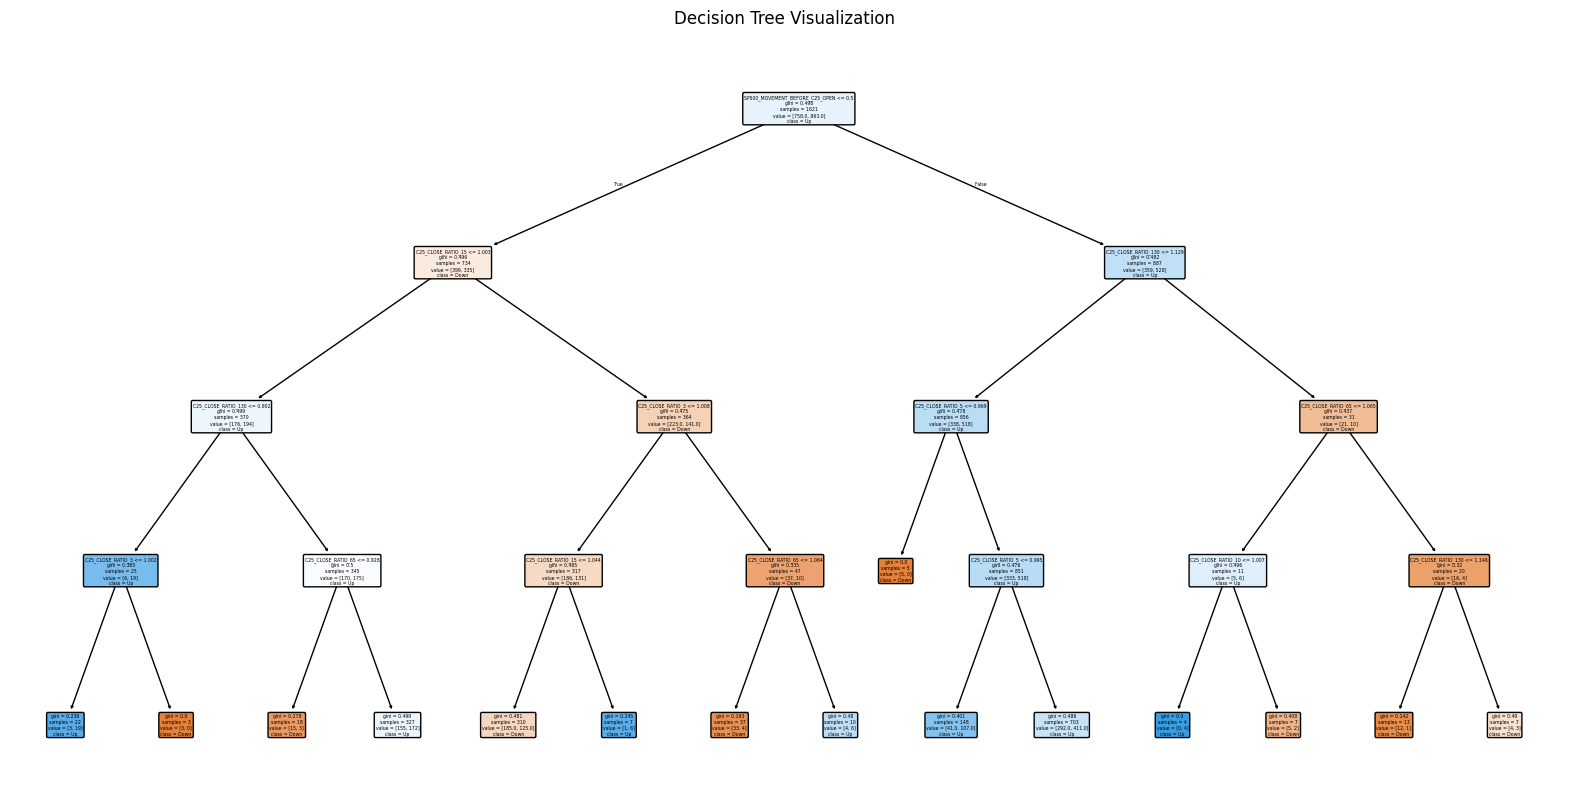

In [417]:
# Model
max_splits = 20
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
# Fjern irrelevante kolonner og angiv den afhængige variabel
X = df.drop(columns=columns_to_drop)
y = df['C25_MOVEMENT']

# Data split
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)

best_n_splits, best_accuracy = evaluate_model(dt_model, X_train, y_train, max_splits)

# Udskriv resultaterne
print(f"Best n_splits: {best_n_splits} with Average Accuracy: {best_accuracy:.2f}")

# Endelig træning med den bedste n_splits
tscv = TimeSeriesSplit(n_splits=best_n_splits)
#model_dt = DecisionTreeClassifier(max_depth=depth_max, random_state=42)

for train_index, val_index in tscv.split(X_train):
    X_train_split, X_val_split = X.iloc[train_index], X.iloc[val_index]
    y_train_split, y_val_split = y.iloc[train_index], y.iloc[val_index]
    
    # Træn modellen
    dt_model.fit(X_train_split, y_train_split)
    
    # Forudsige på testdata
    y_pred = dt_model.predict(X_val_split)

#print(y_pred)
# Udfør den endelige evaluering
y_test_pred = dt_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"tests result of y_pred vs x test. Final Accuracy on last fold with best n_splits: {accuracy:.2f}")

# Visualisér Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Down', 'Up'], filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

Confusion Matrix:
[[ 45 152]
 [ 43 197]]


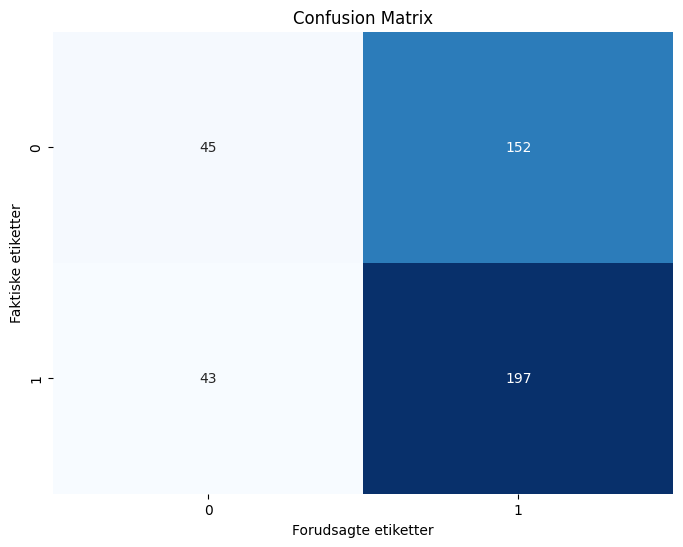

In [418]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualisering af Confusion Matrix som heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Forudsagte etiketter")
plt.ylabel("Faktiske etiketter")
plt.show()

## Random Forrest Classifier

In [315]:
#df_cleaned.to_csv("../app/data/sp500_c25.csv", index=False)

In [457]:
df_cleaned.columns

Index(['LAST_CLOSE_SP500', 'LAST_CLOSE_C25', 'CHANGE_C25', 'C25_TOMORROW',
       'C25_MOVEMENT', 'SP500_TOMORROW', 'SP500_MOVEMENT',
       'SP500_MOVEMENT_BEFORE_C25_OPEN', 'C25_CLOSE_RATIO_3', 'C25_Trend_3',
       'SP500_Trend_3', 'C25_CLOSE_RATIO_5', 'C25_Trend_5', 'SP500_Trend_5',
       'C25_CLOSE_RATIO_10', 'C25_Trend_10', 'SP500_Trend_10',
       'C25_CLOSE_RATIO_15', 'C25_Trend_15', 'SP500_Trend_15',
       'C25_CLOSE_RATIO_20', 'C25_Trend_20', 'SP500_Trend_20',
       'C25_CLOSE_RATIO_65', 'C25_Trend_65', 'SP500_Trend_65',
       'C25_CLOSE_RATIO_130', 'C25_Trend_130', 'SP500_Trend_130',
       'C25_CLOSE_RATIO_260', 'C25_Trend_260', 'SP500_Trend_260'],
      dtype='object')

In [459]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
train = df_cleaned.iloc[:-100]
test = df_cleaned.iloc[-100:]
predictors = [#'LAST_CLOSE_SP500', 'LAST_CLOSE_C25', 'CHANGE_C25', 'C25_TOMORROW',
       #'C25_MOVEMENT', 'SP500_TOMORROW', 'SP500_MOVEMENT',
       'SP500_MOVEMENT_BEFORE_C25_OPEN', 'C25_CLOSE_RATIO_3', 'C25_Trend_3',
       'SP500_Trend_3', 'C25_CLOSE_RATIO_5', 'C25_Trend_5', 'SP500_Trend_5',
       'C25_CLOSE_RATIO_10', 'C25_Trend_10', 'SP500_Trend_10',
       'C25_CLOSE_RATIO_15', 'C25_Trend_15', 'SP500_Trend_15',
       'C25_CLOSE_RATIO_20', 'C25_Trend_20', 'SP500_Trend_20',
       'C25_CLOSE_RATIO_65', 'C25_Trend_65', 'SP500_Trend_65',
       'C25_CLOSE_RATIO_130', 'C25_Trend_130', 'SP500_Trend_130',
       'C25_CLOSE_RATIO_260', 'C25_Trend_260', 'SP500_Trend_260']

model.fit(train[predictors], train['C25_MOVEMENT'])

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [460]:
test['C25_MOVEMENT'].value_counts()

C25_MOVEMENT
1    54
0    46
Name: count, dtype: int64

In [461]:
preds = model.predict(test[predictors])

In [462]:
preds = pd.Series(preds, index=test.index)

In [463]:
preds

Date
2024-05-14    1
2024-05-15    0
2024-05-16    0
2024-05-17    1
2024-05-21    0
             ..
2024-10-02    1
2024-10-03    1
2024-10-04    1
2024-10-07    0
2024-10-08    1
Length: 100, dtype: int64

In [464]:
precision_score(test['C25_MOVEMENT'], preds)

0.5466666666666666

In [465]:
print(f"Predictions distribution: {np.bincount(preds)}")


Predictions distribution: [25 75]


In [466]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['C25_MOVEMENT'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['C25_MOVEMENT'], preds], axis=1)
    return combined

In [467]:
def backtest(data, model, predictors, start=1250, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [469]:
predictions = backtest(df_cleaned, model, predictors)
predictions['Predictions'].value_counts()

Predictions
1    639
0    293
Name: count, dtype: int64

In [470]:
precision_score(predictions['C25_MOVEMENT'], predictions['Predictions'])

0.5539906103286385

In [478]:
def predict_probability(train, test, predictors, model):
    model.fit(train[predictors], train['C25_MOVEMENT'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['C25_MOVEMENT'], preds], axis=1)
    return combined

In [472]:
def backtest_probability(data, model, predictors, start=1000, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step): #starts at row 1000, stops at data frame size, increments by 250 for each loop
        train = data.iloc[0:i].copy() #from 1000:1250 (first loop)
        test = data.iloc[i:(i+step)].copy() #from 1250:1500 (first loop)
        predictions = predict_probability(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [474]:
df_cleaned.shape[0]

2182

In [479]:
predictions = backtest_probability(df_cleaned, model, predictors)

In [480]:
predictions['Predictions'].value_counts()

Predictions
0.0    928
1.0    254
Name: count, dtype: int64

In [481]:
precision_score(predictions['C25_MOVEMENT'], predictions['Predictions'])

0.610236220472441